In [3]:
import warnings
import re
import math
import string
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, BaggingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeRegressor
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from catboost import CatBoostClassifier

from wordcloud import WordCloud
from nltk.corpus import twitter_samples
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [4]:
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/ritayanpatra/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ritayanpatra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritayanpatra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading

In [5]:
data_df = pd.read_json('./data/Sarcasm_Headlines_Dataset.json', lines=True)

print(data_df.shape)
data_df.head()

(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
data_df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [7]:
X = data_df['headline']
y = data_df['is_sarcastic'] 
print(X.shape, y.shape)

(26709,) (26709,)


## Data Split

Class Distribution: 
 is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


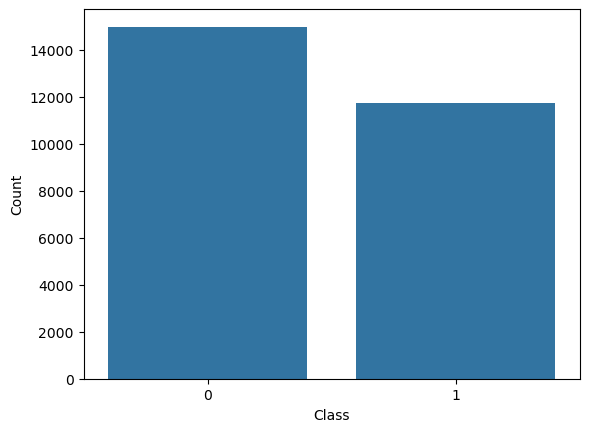

In [8]:
cd = y.value_counts()
print("Class Distribution: \n", cd)

sns.barplot(x=cd.index, y=cd.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [9]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape} {X_test.shape} | Test: {X_val.shape} {y_val.shape} | Test: {X_test.shape} {y_test.shape}")

Train: (17093,) (5342,) | Test: (4274,) (4274,) | Test: (5342,) (5342,)


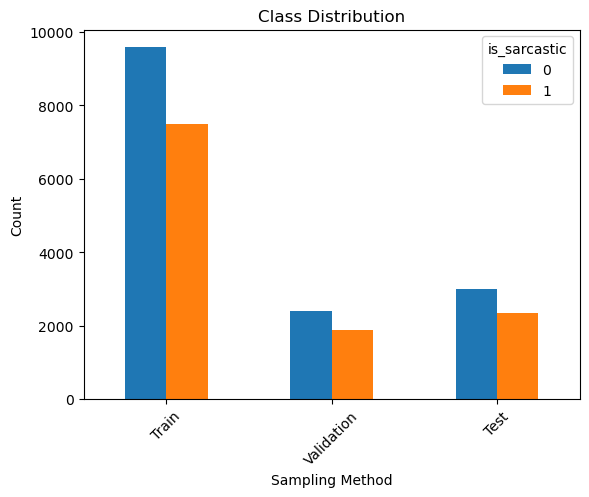

In [10]:
cd_train = y_train.value_counts()
cd_val = y_val.value_counts()
cd_test = y_test.value_counts()

cd_df = pd.DataFrame({
    'Train': cd_train,
    'Validation': cd_val,
    'Test': cd_test,
})

cd_df.T.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Sampling Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Preprocessing

In [11]:
def text_cleaning(text):
    text = re.sub(r"[^A-Za-z0-9']", " ", text) # keep single quote for sarcasm
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text)
    text = text.lower()
    return text

In [12]:
X_train = X_train.reset_index(drop = True)
count = 0
for i in range(len(X_train)):
    original_text = X_train[i]
    cleaned_text = text_cleaning(original_text)
    
    if original_text != cleaned_text:
        print("Original: ", original_text)
        print("Cleaned: ", cleaned_text)
        print("-" * 50)
        count +=1
    if count>=10: break

Original:  instagram influencers are all starting to look the same. here's why.
Cleaned:  instagram influencers are all starting to look the same  here  why 
--------------------------------------------------
Original:  researchers say that first warning sign of alcoholism generally driving over curb, plowing through fire hydrant, and crashing into aquarium
Cleaned:  researchers say that first warning sign of alcoholism generally driving over curb  plowing through fire hydrant  and crashing into aquarium
--------------------------------------------------
Original:  5 essential lists to make before the end of this year
Cleaned:  essential lists to make before the end of this year
--------------------------------------------------
Original:  controversial study links e-cigarettes to formaldehyde exposure
Cleaned:  controversial study links e cigarettes to formaldehyde exposure
--------------------------------------------------
Original:  here's christine baranski watching trump's inaugur

In [13]:
X_test = X_test.reset_index(drop = True)
for i in range(len(X_test)):
    original_text = X_test[i]
    cleaned_text = text_cleaning(original_text)

X_val = X_val.reset_index(drop = True)
for i in range(len(X_val)):
    original_text = X_val[i]
    cleaned_text = text_cleaning(original_text)

In [14]:
stopwords = set(stopwords.words('english'))
def remove_stopwords(sentence):
    words = sentence.split()
    clean_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(clean_words)
x_train_clean = X_train.apply(remove_stopwords)
x_val_clean = X_val.apply(remove_stopwords)
x_test_clean = X_test.apply(remove_stopwords)
print(x_train_clean.head(10))

0    instagram influencers starting look same. here...
1    researchers say first warning sign alcoholism ...
2                           failing way success brazil
3      nation kept night sound creaking infrastructure
4                      5 essential lists make end year
5    materialistic single mom constantly thinking m...
6                     man forgets infant strapped back
7    controversial study links e-cigarettes formald...
8    here's christine baranski watching trump's ina...
9                        ovarian cancer gets publicist
Name: headline, dtype: object


In [15]:
def remove_punctuations(sentence):
    return sentence.translate(str.maketrans('', '', string.punctuation))
x_train_clean = x_train_clean.apply(remove_punctuations)
x_val_clean = x_val_clean.apply(remove_punctuations)
x_test_clean = x_test_clean.apply(remove_punctuations)
print(x_train_clean.head(10))

0    instagram influencers starting look same heres...
1    researchers say first warning sign alcoholism ...
2                           failing way success brazil
3      nation kept night sound creaking infrastructure
4                      5 essential lists make end year
5    materialistic single mom constantly thinking m...
6                     man forgets infant strapped back
7    controversial study links ecigarettes formalde...
8    heres christine baranski watching trumps inaug...
9                        ovarian cancer gets publicist
Name: headline, dtype: object


## Feature Extraction

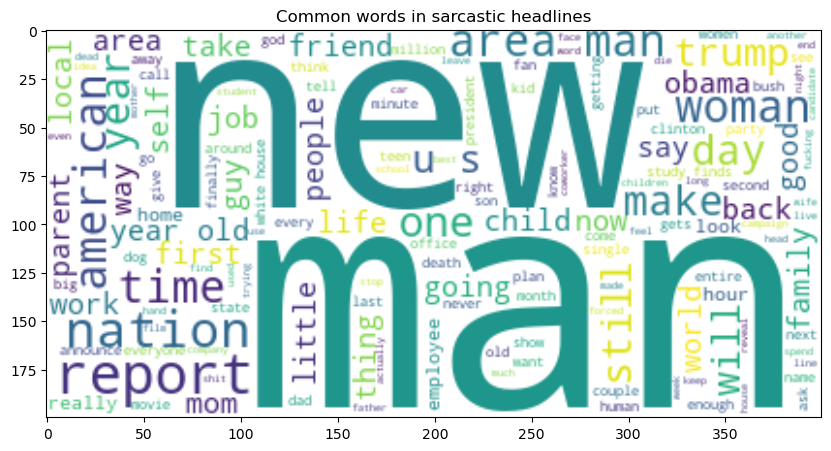

In [16]:
wc = WordCloud(background_color='white').generate(' '.join(data_df[data_df['is_sarcastic'] == 1].headline))

plt.figure(figsize=(10, 12))
plt.imshow(wc, interpolation='bilinear')
plt.title("Common words in sarcastic headlines")
plt.show()

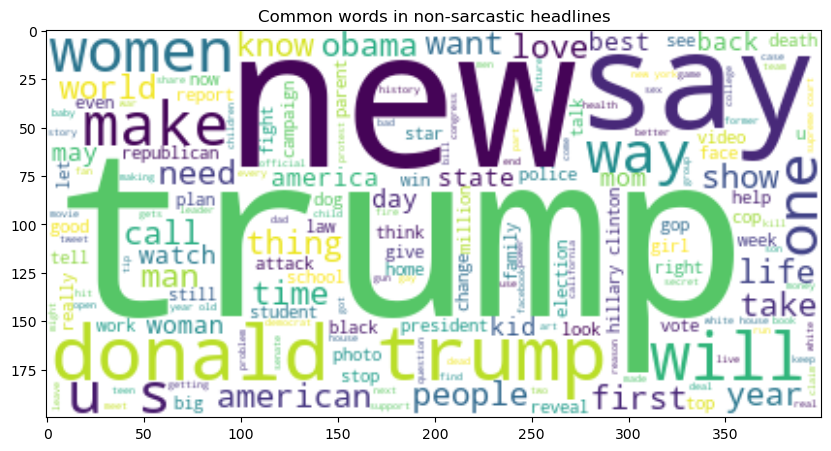

In [17]:
wc = WordCloud(background_color='white').generate(' '.join(data_df[data_df['is_sarcastic'] == 0].headline))

plt.figure(figsize=(10, 12))
plt.imshow(wc, interpolation='bilinear')
plt.title("Common words in non-sarcastic headlines")
plt.show()

## Bag of Words

In [18]:
vector = CountVectorizer()
x_train_vectors = vector.fit_transform(x_train_clean)
x_val_vectors = vector.transform(x_val_clean)
x_test_vectors = vector.transform(x_test_clean)
x_train_vectors

<17093x22743 sparse matrix of type '<class 'numpy.int64'>'
	with 120641 stored elements in Compressed Sparse Row format>

In [19]:
model_bow = LogisticRegression()
model_bow.fit(x_train_vectors, y_train)

LogisticRegression()

In [20]:
y_pred_bow = model_bow.predict(x_test_vectors)
y_pred_bow

array([0, 0, 1, ..., 0, 1, 0])

Accuracy: 0.7884687383002621

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      2997
           1       0.79      0.70      0.74      2345

    accuracy                           0.79      5342
   macro avg       0.79      0.78      0.78      5342
weighted avg       0.79      0.79      0.79      5342



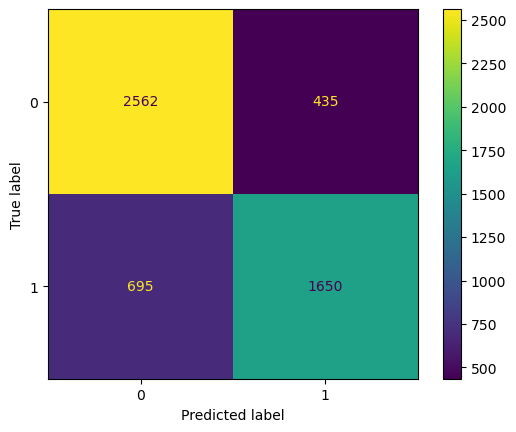

In [21]:
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print(f"Accuracy: {accuracy_bow}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_bow))
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_bow))
disp.plot()

## TF-IDF

In [22]:
vector = TfidfVectorizer(max_features = 5000)
x_train_vectors = vector.fit_transform(x_train_clean)
x_val_vectors = vector.transform(x_val_clean)
x_test_vectors = vector.transform(x_test_clean)

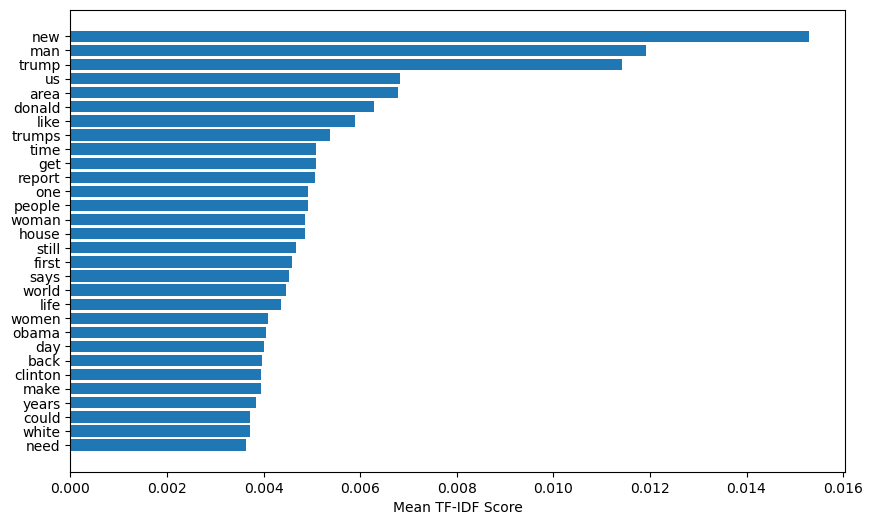

In [23]:
score_df = pd.DataFrame({"word": vector.get_feature_names_out(), "mean_tfidf": x_test_vectors.mean(axis = 0).A1})
top_words = score_df.nlargest(30, "mean_tfidf")

plt.figure(figsize=(10, 6))
plt.barh(top_words["word"], top_words["mean_tfidf"], align="center")
plt.gca().invert_yaxis()
plt.xlabel("Mean TF-IDF Score")
plt.show()

## Regressor/Tree-Based Models (TF-IDF)

In [24]:
tree_models = {
    "Logistic Regressor": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(verbose=0),
    "Extra Trees": ExtraTreesClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging": BaggingClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

param_grids = {
    "Logistic Regressor":{
        "penalty": ["l1", "l2"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "solver": ["liblinear", "saga"],
        "max_iter": [5000]
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [10, 20, 30, 50, None],
        "min_samples_split": [2, 5, 10, 25],
        "min_samples_leaf": [1, 2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200, 500],
        "max_depth": [10, 20, 40, None],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2", None]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
        "max_depth": [3, 5, 7],
        "subsample": [0.7, 0.8, 1.0]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
        "max_depth": [3, 5, 7],
        "eval_metric": ["logloss"],
        "colsample_bytree": [0.7, 0.8, 1.0],
        "gamma": [0, 0.1, 0.3, 0.5]
    },
    "LightGBM": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "num_leaves": [20, 31, 40],
        "max_bin": [63, 127, 255],
        "min_child_samples": [10, 20, 30, 50],
        "boosting_type": ["gbdt", "dart"]
    },
    "Extra Trees": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2", None],
        "min_samples_leaf": [1, 2, 5],
        "bootstrap": [True, False]
    },
    "AdaBoost": {
        "n_estimators": [10, 50, 100, 200, 500],
        "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
        "algorithm": ["SAMME"],
    },              
    "Bagging": {
        "n_estimators": [10, 25, 50, 100],
        "max_samples": [0.5, 0.7, 0.9, 1.0],
        "max_features": [0.2, 0.5, 0.8, 1.0],
        "bootstrap": [True, False]
    },
    "CatBoost":{
        "iterations": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "depth": [3, 5, 7],
        "l2_leaf_reg": [1, 3, 5, 10],
        "bagging_temperature": [0, 0.5, 1.0],
        "grow_policy": ["SymmetricTree", "Depthwise", "Lossguide"]
    },
}

In [25]:
tree_results = {}
for model_name, model in tree_models.items():
    print(f"Training {model_name}...")
    
    search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[model_name],
        n_iter=20,
        scoring={
            'f1': make_scorer(f1_score, average='weighted'),
            'accuracy': make_scorer(accuracy_score)
        },
        refit='f1',  
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    search.fit(x_train_vectors, y_train)
    tree_results[model_name] = {"cv_results": pd.DataFrame(search.cv_results_), "best_estimator": search.best_estimator_}

Training Logistic Regressor...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Decision Tree...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Gradient Boosting...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training LightGBM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Extra Trees...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training AdaBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Bagging...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training CatBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


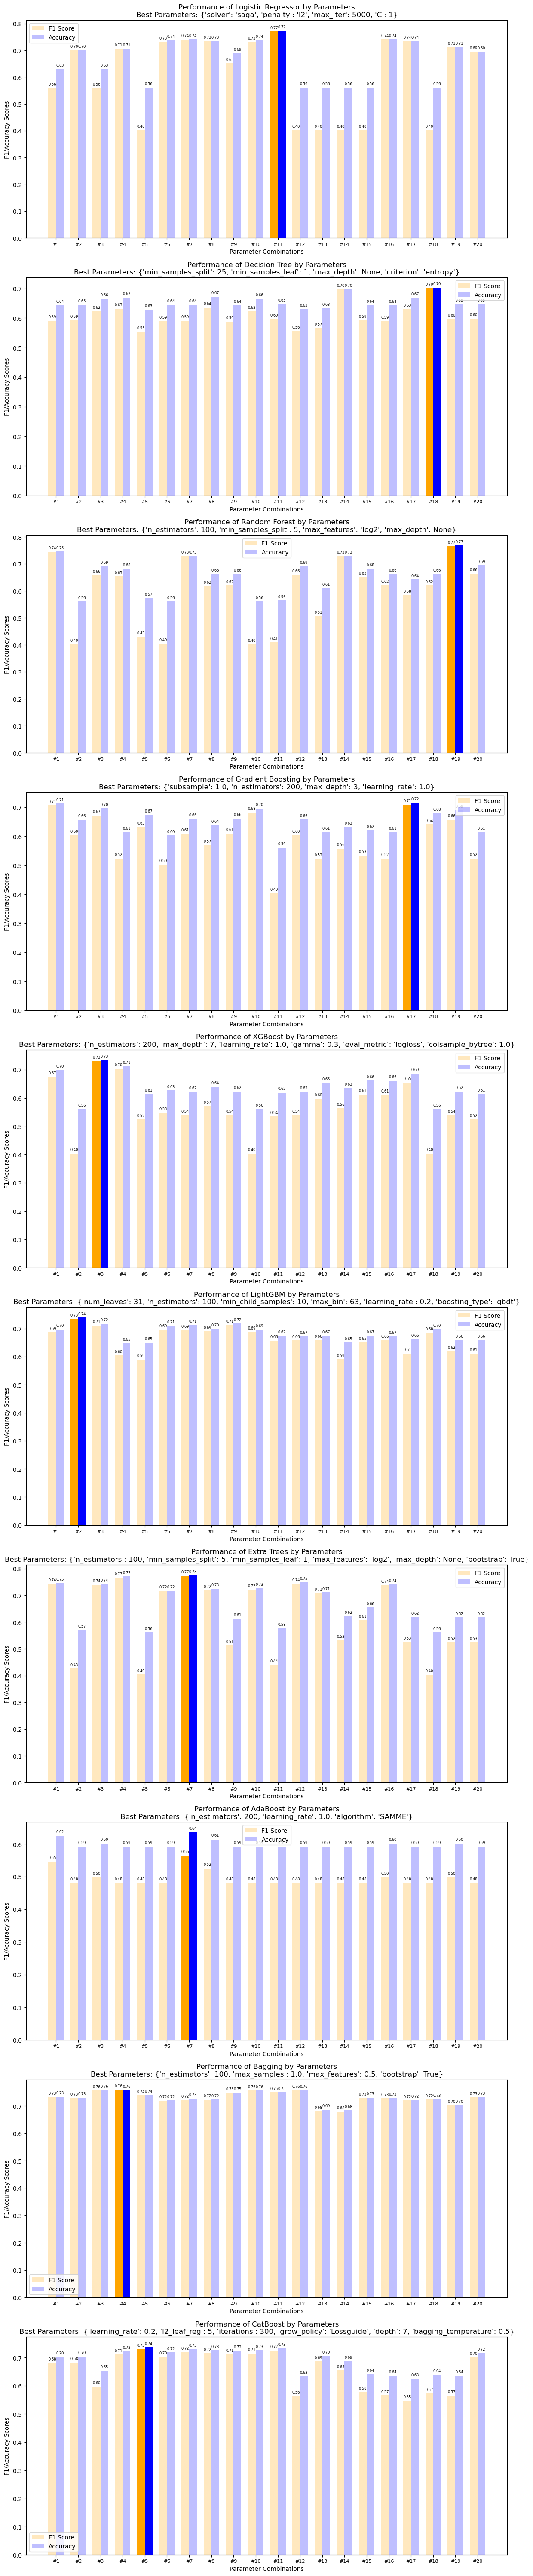

In [26]:
fig, axes = plt.subplots(len(tree_results), 1, figsize=(12, 6 * len(tree_results)))

for ax, (model_name, model_data) in zip(axes, tree_results.items()):
    # Best parameter combination
    best_index = model_data["cv_results"]["rank_test_f1"].idxmin()
  
    # F1 and Accuracy Scores
    f1_scores = model_data["cv_results"]["mean_test_f1"]
    accuracy_scores = model_data["cv_results"]["mean_test_accuracy"]

    for i, f1 in enumerate(f1_scores):
        ax.bar(
            i - 0.35 / 2,
            f1,
            width=0.35,
            color='orange' if i == best_index else 'orange',
            alpha=1.0 if i == best_index else 0.25,
            label='F1 Score' if i == 0 else None
        )
    for i, acc in enumerate(accuracy_scores):
        ax.bar(
            i + 0.35 / 2,
            acc,
            width=0.35,
            color='blue' if i == best_index else 'blue',
            alpha=1.0 if i == best_index else 0.25,
            label='Accuracy' if i == 0 else None
        )

    for i, (f1, acc) in enumerate(zip(f1_scores, accuracy_scores)):
        ax.text(i - 0.35 / 2, f1 + 0.01, f"{f1:.2f}", ha="center", fontsize=6)
        ax.text(i + 0.35 / 2, acc + 0.01, f"{acc:.2f}", ha="center", fontsize=6)

    ax.set_title(f"Performance of {model_name} by Parameters\nBest Parameters: {model_data["cv_results"].loc[best_index, "params"]}")
    ax.set_xlabel("Parameter Combinations")
    ax.set_ylabel("F1/Accuracy Scores")
    ax.set_xticks(range(len(model_data["cv_results"])))
    ax.set_xticklabels([f"#{i+1}" for i in range(len(model_data["cv_results"]))], rotation=0, ha="center", fontsize=8)
    ax.legend()

plt.tight_layout()
plt.show()

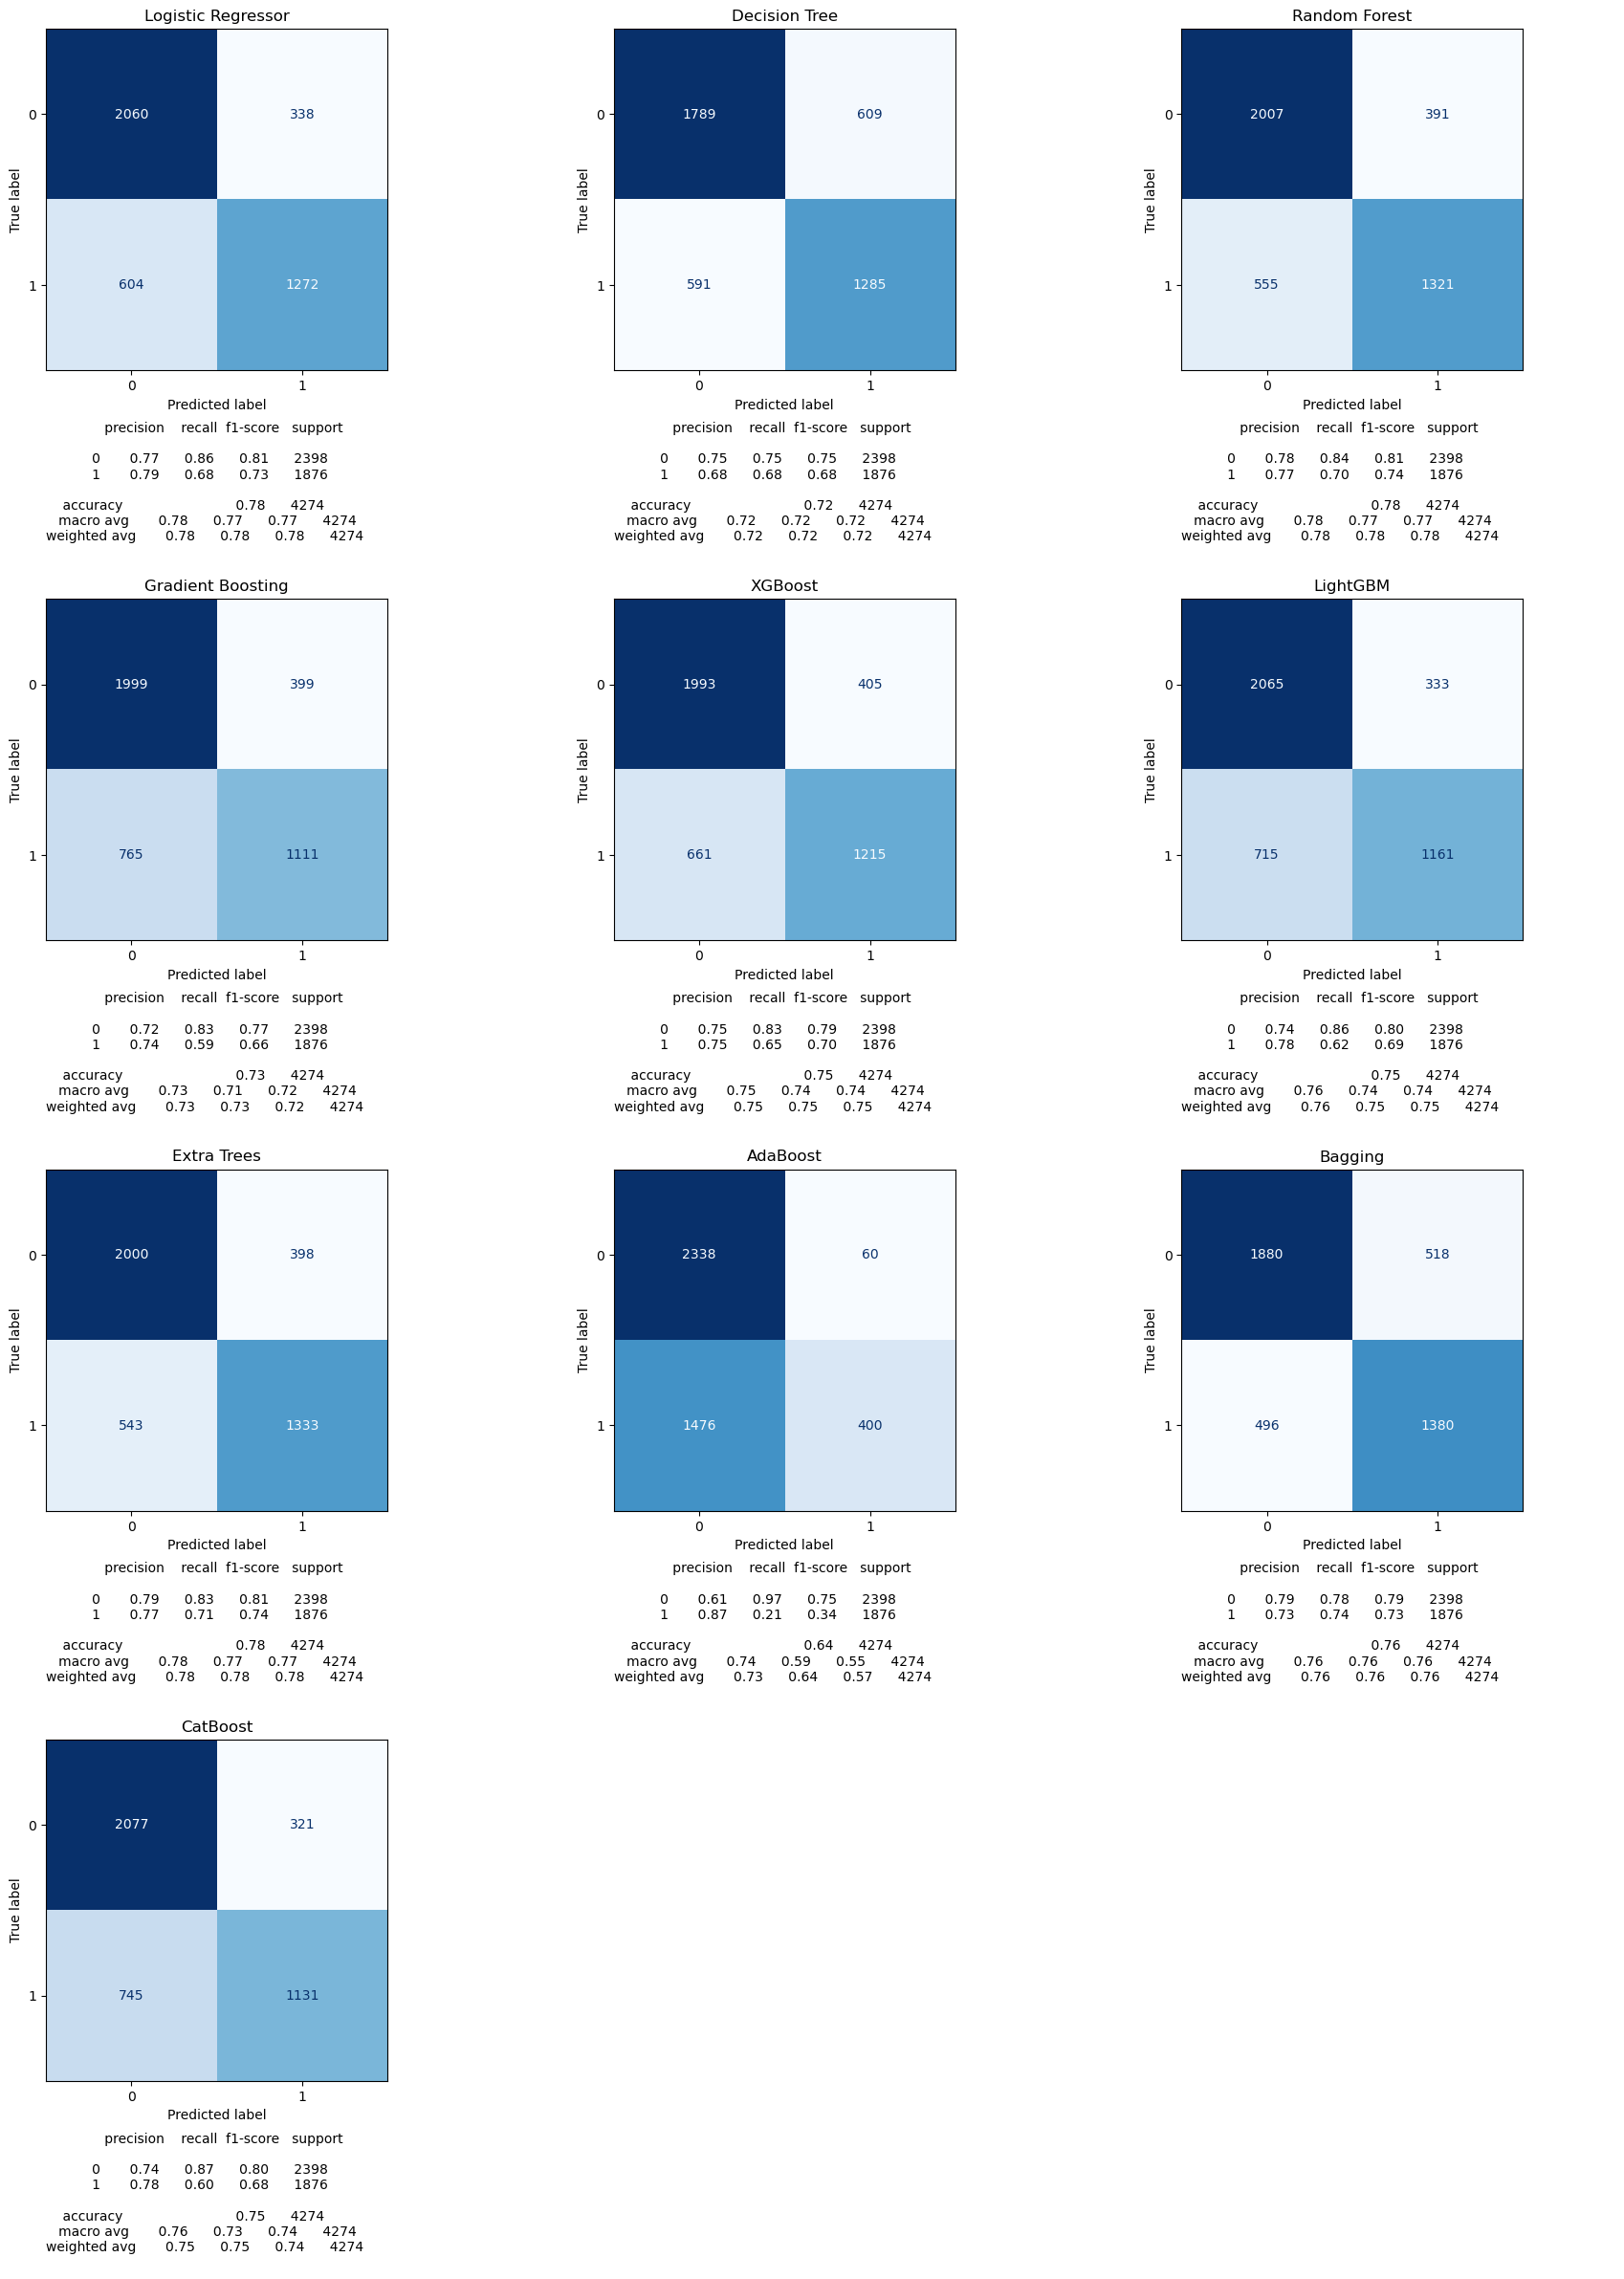

In [27]:
n_rows = math.ceil(len(tree_results) / 3)
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows))

for ax, (model_name, model_data) in zip(axes.flatten(), tree_results.items()):
    best_model = model_data["best_estimator"]
    y_val_pred = best_model.predict(x_val_vectors)

    # Confusion_matrix
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"{model_name}")

    # Classification report
    report = classification_report(y_val, y_val_pred)
    ax.text(0.0, -0.15, report, transform=ax.transAxes, fontsize=10, va='top', wrap=True)

# Unused subplots
for ax in axes.flatten()[len(tree_results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

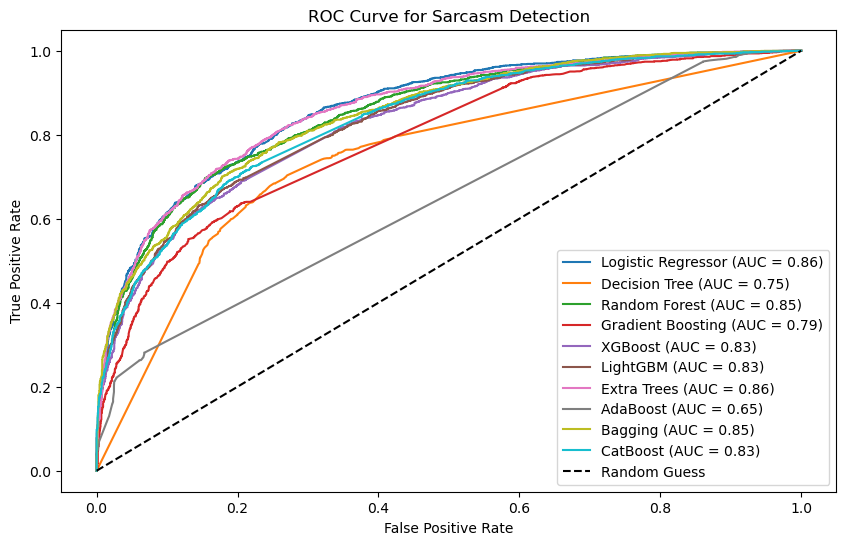

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, model_data in tree_results.items():
    best_model = model_data["best_estimator"]

    # Probabilities for is_sarcastic=1
    y_val_proba = best_model.predict_proba(x_val_vectors)[:, 1]

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    auc_score = roc_auc_score(y_val, y_val_proba)

    ax.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

ax.plot([0, 1], [0, 1], "k--", label="Random Guess") # For reference
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve for Sarcasm Detection")
ax.legend(loc="lower right")
plt.show()

### Long Short Term Memory (LSTM) Deep Learning Model

The information source: @https://medium.com/@neri.vvo/how-to-use-lstm-in-nlp-tasks-text-classification-example-3222db759337#:~:text=In%20NLP%2C%20LSTMs%20are%20typically,previous%20inputs%20in%20%E2%80%9Cmemory.%E2%80%9D

Natural language processing (NLP) tasks frequently employ the Recurrent Neural Network (RNN) variant known as Long Short-Term Memory (LSTM). RNNs are neural networks that process sequential data, such as time series data or text written in a natural language.

### Central Role of an LSTM Model

- **Cell State**: 
  - The key component of an LSTM model is the **cell state**, which maintains its state over time.
  - The **cell state** can be visualized as a horizontal line running through the top of the diagram.
  - The cell state functions like a conveyor belt through which information flows, mostly unchanged.
  - Information can be added or removed from the cell state through gates, which control the flow of information in and out.

- **Gates in LSTM**:
  - LSTMs have a set of gates that regulate the flow of information:
    - **Input Gate**: Controls the flow of new information into the cell.
    - **Forget Gate**: Regulates the flow of information out of the cell.
    - **Output Gate**: Manages the data flow into the LSTM’s output.

- **Mechanism of Operation**:
  - LSTMs use a system of **memory cells** that store information and transmit it across time steps.
  - These cells are interconnected by gates, which ensure that only the relevant information is retained and passed along.
  - The gates employ pointwise multiplication and a **sigmoid neural net layer** to manage the information flow.

### Summary of Gate Functions
- **Input Gate**: Adds new information to the cell state.
- **Forget Gate**: Removes unnecessary information from the cell state.
- **Output Gate**: Sends relevant information to the output.
  
By controlling the flow of information in this way, LSTMs can **forget irrelevant information** while **retaining important data** over longer sequences.

### Preprocessing 

In [29]:
lemmatizer = WordNetLemmatizer()
def apply_lemmatize(text):
    words = text.split()
    res = []
    for word in words:
        word = lemmatizer.lemmatize(word, pos='v')
        res.append(word)
    
    return ' '.join(res)


In [30]:
x_train_lemma = x_train_clean.apply(apply_lemmatize)
x_val_lemma = x_val_clean.apply(apply_lemmatize)
x_test_lemma = x_test_clean.apply(apply_lemmatize)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, BatchNormalization, SpatialDropout1D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [32]:
max_features = 500000  # Maximum number of words to keep
max_length = 30

tokenizer = Tokenizer(
    num_words=max_features,    
    split=' ',                 
    filters=string.punctuation,  
    lower=True                
)

In [33]:
tokenizer.fit_on_texts(x_train_lemma.values)

In [35]:
x_train_token = tokenizer.texts_to_sequences(x_train_lemma)
x_train_token = pad_sequences(x_train_token, maxlen=max_length, padding='post', truncating='post')
x_test_token = tokenizer.texts_to_sequences(x_test_lemma)
x_test_token = pad_sequences(x_test_token, maxlen=max_length, padding='post', truncating='post')
x_val_token = tokenizer.texts_to_sequences(x_val_lemma)
x_val_token = pad_sequences(x_val_token, maxlen=max_length, padding='post', truncating='post')

In [36]:
x_train_token

array([[ 1481,  9422,   155, ...,     0,     0,     0],
       [ 1327,     6,    18, ...,     0,     0,     0],
       [  261,    64,   788, ...,     0,     0,     0],
       ...,
       [19123, 19124,   404, ...,     0,     0,     0],
       [  152,   207,   244, ...,     0,     0,     0],
       [  155, 19125,  1222, ...,     0,     0,     0]], dtype=int32)

In [37]:
print('Found %s unique tokens.' % len(tokenizer.word_index))
print('Sequence shape:', x_train_token.shape)

Found 19125 unique tokens.
Sequence shape: (17093, 30)


In [64]:
model = Sequential()
model.add(Embedding(
                input_dim=len(tokenizer.word_index) + 1, 
                output_dim=30,
                input_length=max_length,
                trainable=True
            )
         )
model.add(SpatialDropout1D(0.3))
model.add(LSTM(50, 
               return_sequences=False,
               recurrent_dropout=0.3,
               kernel_regularizer=l2(0.001)
              )
         )
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(
                30, 
                activation='relu', 
                kernel_regularizer=l2(0.001)
            )
         )
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])
model.build(input_shape=(None, max_length))
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 30, 30)         │       573,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 30, 30)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        16,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,741 (2.26 MB)

 Trainable params: 591,641 (2.26 MB)

 Non-trainable params: 100 (400.00 B)

In [65]:
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=20,             # Stop if no improvement for 10 epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Monitor validation loss
    factor=0.2,              # Reduce learning rate by 80%
    patience=5,              # Wait 5 epochs before reducing learning rate
    min_lr=0.00001           # Minimum learning rate
)


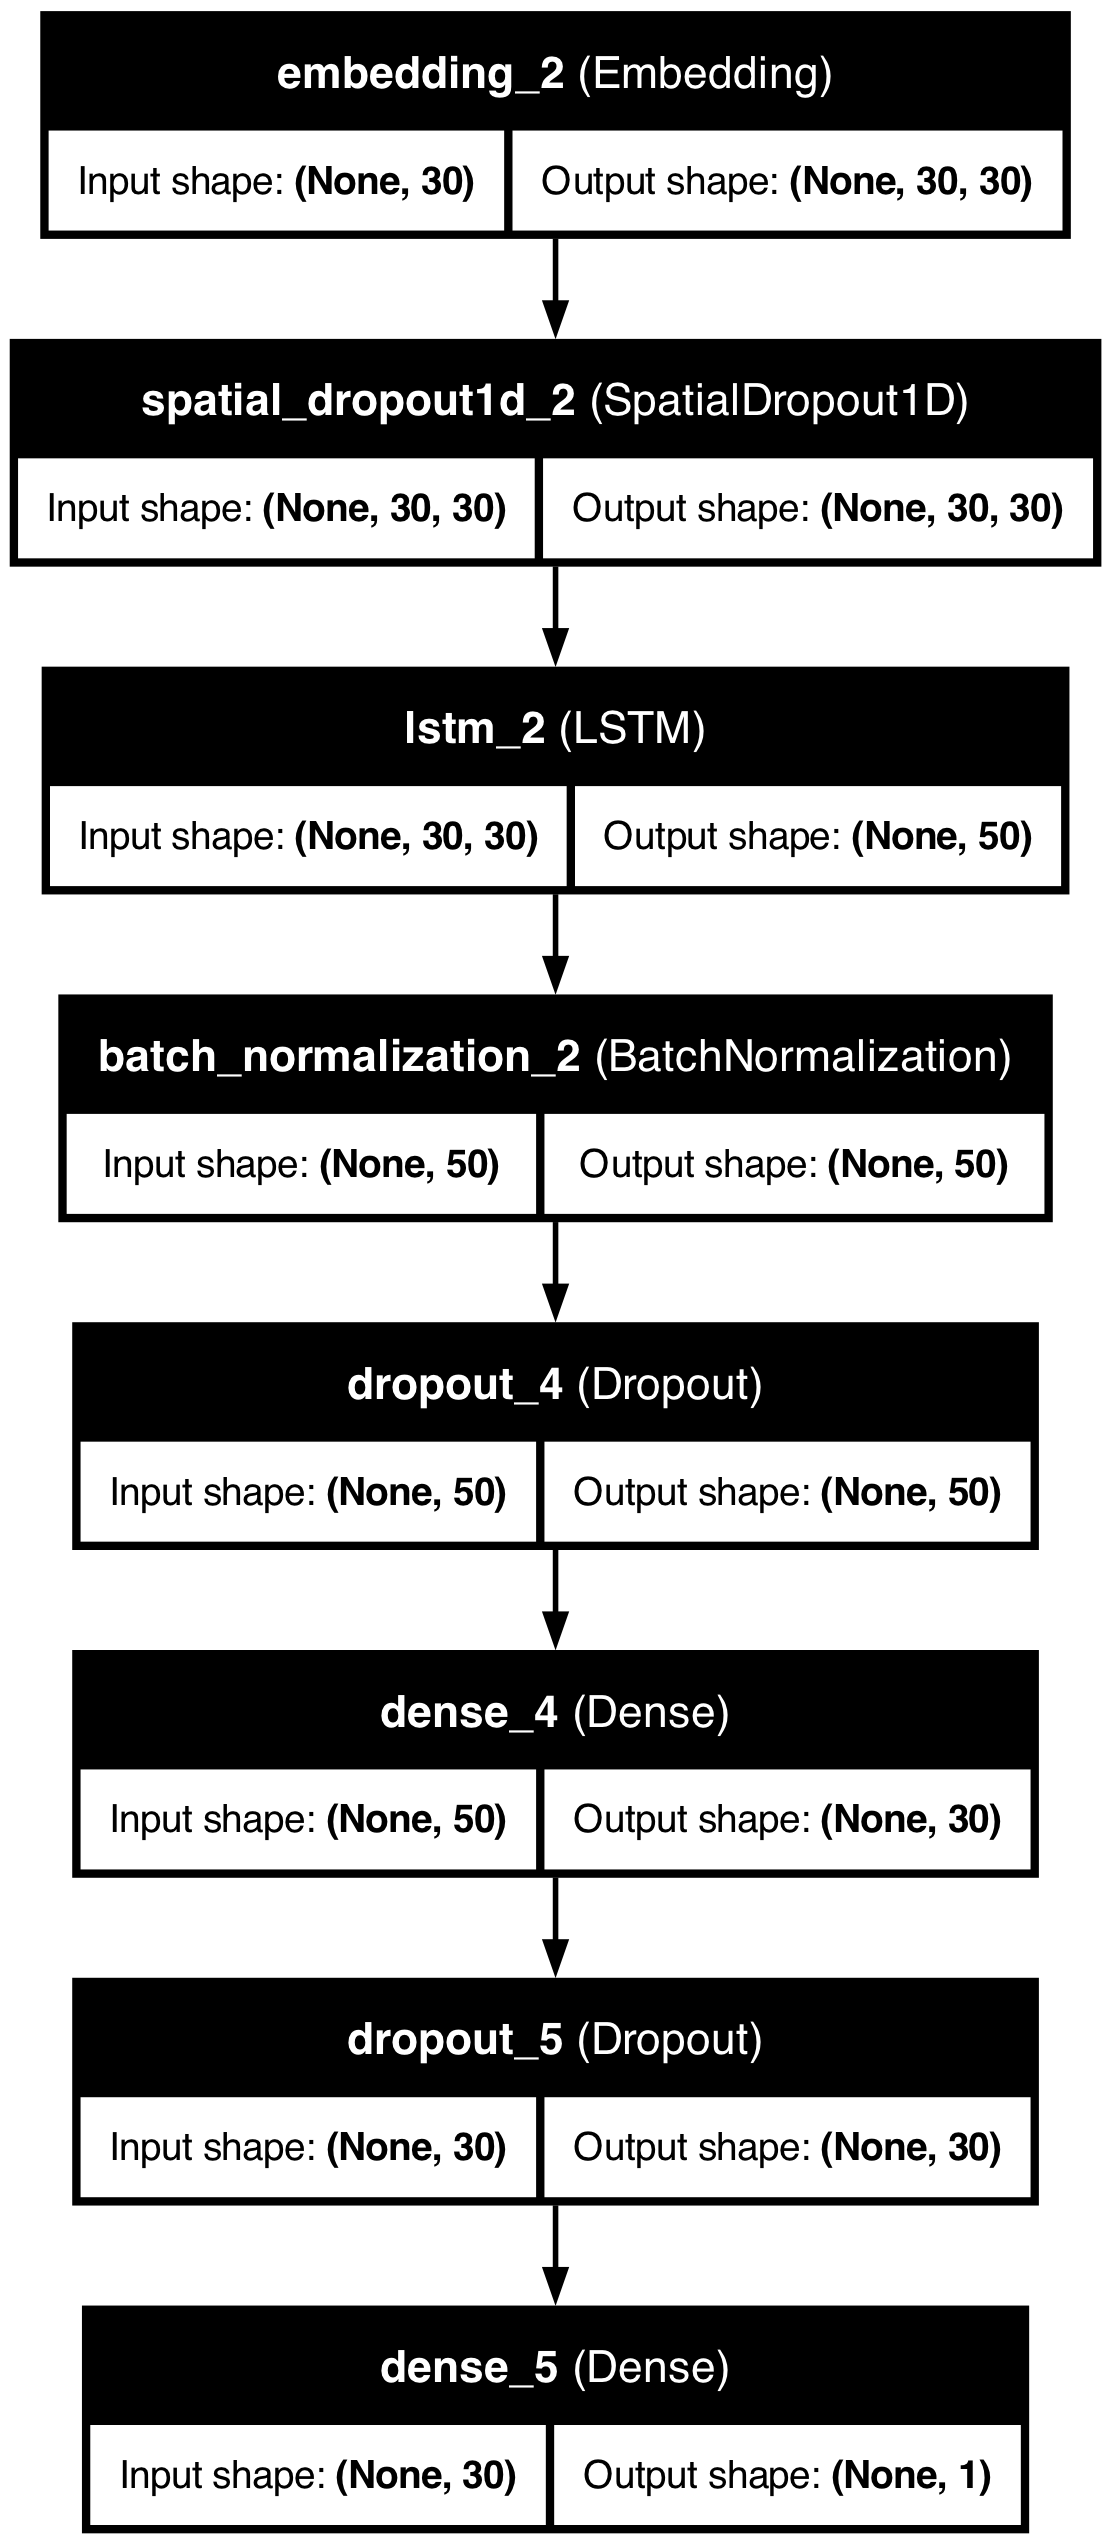

In [66]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [67]:
batch_size = 32
history=model.fit(
    x_train_token, 
    y_train, epochs=50, 
    batch_size=batch_size, 
    validation_data=(x_test_token, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose = 2)

Epoch 1/50
535/535 - 8s - 15ms/step - acc: 0.5424 - loss: 0.7377 - val_acc: 0.5610 - val_loss: 0.7163 - learning_rate: 0.0010
Epoch 2/50
535/535 - 6s - 11ms/step - acc: 0.5596 - loss: 0.7093 - val_acc: 0.5610 - val_loss: 0.7014 - learning_rate: 0.0010
Epoch 3/50
535/535 - 6s - 11ms/step - acc: 0.5610 - loss: 0.6979 - val_acc: 0.5610 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 4/50
535/535 - 5s - 9ms/step - acc: 0.6953 - loss: 0.6027 - val_acc: 0.7553 - val_loss: 0.5517 - learning_rate: 0.0010
Epoch 5/50
535/535 - 5s - 10ms/step - acc: 0.8249 - loss: 0.4641 - val_acc: 0.7742 - val_loss: 0.5310 - learning_rate: 0.0010
Epoch 6/50
535/535 - 5s - 10ms/step - acc: 0.8821 - loss: 0.3508 - val_acc: 0.7681 - val_loss: 0.5777 - learning_rate: 0.0010
Epoch 7/50
535/535 - 6s - 10ms/step - acc: 0.9183 - loss: 0.2771 - val_acc: 0.7832 - val_loss: 0.4977 - learning_rate: 0.0010
Epoch 8/50
535/535 - 5s - 10ms/step - acc: 0.9341 - loss: 0.2353 - val_acc: 0.7748 - val_loss: 0.6084 - learning_rate: 

In [68]:
test_loss, test_accuracy = model.evaluate(x_test_token, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")

Test accuracy: 0.78
Test loss: 0.50


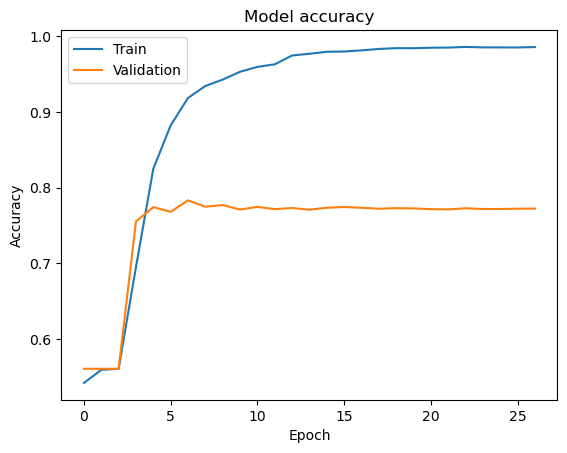

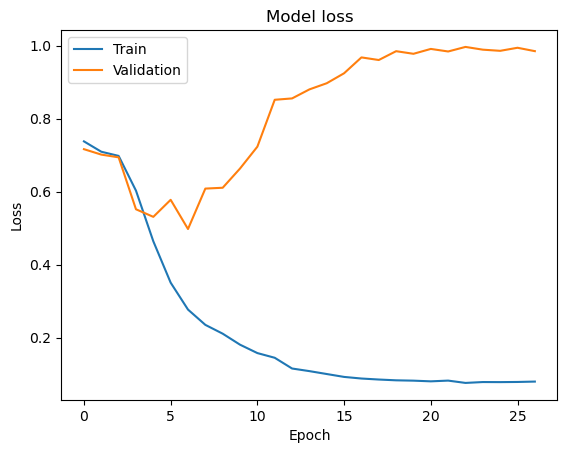

In [69]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [70]:
_, train_acc = model.evaluate(x_train_token, y_train, verbose=2)
_, test_acc = model.evaluate(x_test_token, y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

535/535 - 1s - 2ms/step - acc: 0.9520 - loss: 0.1993
167/167 - 0s - 2ms/step - acc: 0.7832 - loss: 0.4977
Train: 0.952, Test: 0.7832


In [71]:
y_pred = (model.predict(x_test_token) >= 0.5).astype("int32")
y_pred

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]], dtype=int32)

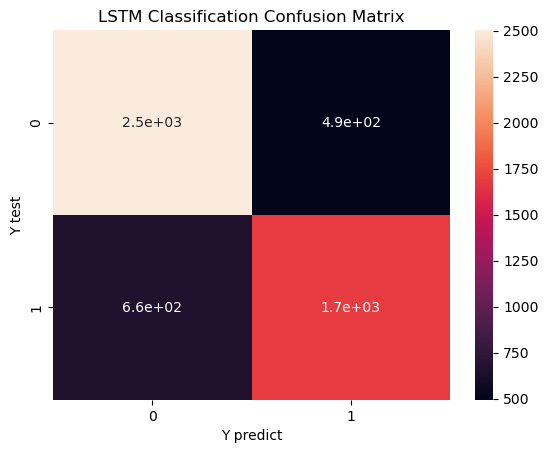

In [72]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

confusion_val = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_val, annot=True)
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      2997
           1       0.77      0.72      0.74      2345

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342

